In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import torch
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AffinityPropagation

from mmcls.models import build_classifier
from mmcls.datasets import build_dataset, build_dataloader
from mmcls.apis import single_gpu_test
from research.configs.classification.resnet.resnet18_cifar100 import baseline
from research.mmlab_extension.classification.resnet_cifar_v2 import ResNet_CIFAR_V2
from mmcv import Config
from mmcv.runner import load_checkpoint



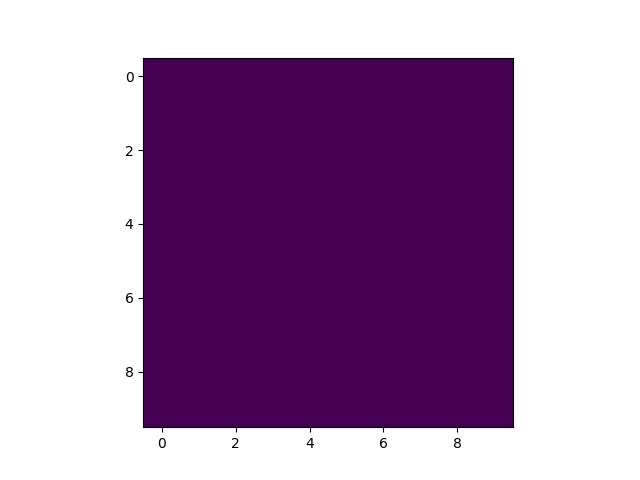

In [2]:
plt.imshow(np.zeros((10, 10)))
plt.show()

In [2]:
config_path = '/workspaces/secure_inference/research/configs/classification/resnet/resnet18_cifar100/baseline.py'
cfg = Config.fromfile(config_path)

dataset = build_dataset(cfg.data.test)
loader_cfg = dict(
        # cfg.gpus will be ignored if distributed
        num_gpus=1,
        dist=False,
        round_up=True,
        shuffle=False,  # Not shuffle by default
        sampler_cfg= None,  # Not use sampler by default
        **cfg.data.get('test_dataloader', {})
    )
loader_cfg.update({
        k: v
        for k, v in cfg.data.items() if k not in [
            'train', 'val', 'test', 'train_dataloader', 'val_dataloader',
            'test_dataloader'
        ]
    })
if 'distortion_extraction' in loader_cfg:
    del loader_cfg['distortion_extraction']
data_loader = build_dataloader(dataset, **loader_cfg)

In [4]:
class SaveActivationHook:
    def __init__(self, channel_idx):
        self.channel_idx = channel_idx
        self.activations = {}

    # def hook(self, module, input, output, layer_name):
    #     channel_output = output[:, self.channel_idx, :, :]
    #         # Save a binary mask where ReLU was 0 (inactive neurons)
    #     if layer_name not in self.activations:
    #         self.activations[layer_name] = []
    #     self.activations[layer_name].append((channel_output > 0).cpu().numpy())

    def get_hook(self, layer_name):
        # Function to be called on each forward pass for the layer
        def hook_fn(module, input, output):
            # Get the specific channel from the output
            channel_output = output[:, self.channel_idx, :, :]
            # Save a binary mask where ReLU was 0 (inactive neurons)
            if layer_name not in self.activations:
                self.activations[layer_name] = []
            self.activations[layer_name].append((channel_output > 0).cpu().numpy())
        return hook_fn
    
    # def _get_activations(self,output):
    #     channel_output = output[:, self.channel_idx, :, :]
    #     return (channel_output > 0).cpu().numpy()


def add_activation_hooks(model, layer_names, channel_idx):
    hook_instance = SaveActivationHook(channel_idx)
    for layer_name in layer_names:
        layer = dict(model.named_modules())[layer_name]
        layer.register_forward_hook(hook_instance.get_hook(layer_name))
    return hook_instance


def get_activation_similarities(activations, metric='l1', mean=True):
    if isinstance(activations, list):
        activations = np.concatenate(activations, axis=0)
    assert activations.ndim == 3
    samples = activations.reshape(activations.shape[0], -1).T
    sim = -pairwise_distances(samples, metric=metric)
    if mean:
        sim /= samples.shape[-1]
    return sim


In [ ]:
model.backbone

In [ ]:
for k in dict(model.named_modules()).keys():
    print(k)

In [7]:
model = build_classifier(cfg.model)
ckpt = '/workspaces/secure_inference/tests/resnet18_10_8/latest.pth'
checkpoint = load_checkpoint(model, ckpt, map_location='cpu')

# layers_for_hook = [
#     'backbone.conv1',
#     'backbone.bn1',
#     'backbone.layer1.0.bn1',
#     'backbone.layer1.1.bn1',
#     'backbone.layer2.0.bn1',
#     'backbone.layer2.1.bn1']
layers_for_hook = [
    'backbone.layer1.0.relu_1',
    'backbone.layer1.0.relu_2',
    'backbone.layer1.1.relu_1',
    'backbone.layer1.1.relu_2'
]
hook = add_activation_hooks(model, layers_for_hook, channel_idx=0)

for i, data in enumerate(data_loader):
    print(f"Processing batch {i+1}")
    out = model.forward_test(data['img'])
    if i+1 >= 25:  # Stop after N examples
        break

load checkpoint from local path: /workspaces/secure_inference/tests/resnet18_10_8/latest.pth
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5


KeyboardInterrupt: 

In [99]:
hook.activations['backbone.layer1.0.relu_1']

[array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False,  True,  True, ..., False, False, False],
         [False,  True,  True, ...,  True,  True,  True],
         [False, False,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False,  True,  True, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False,  True,  True, ..., False, False, False],
         [False,  True, 

In [108]:
act = hook.activations['backbone.layer1.1.relu_2']
act = np.concatenate(act, axis=0)
s = act.reshape(act.shape[0], -1).T
# s.shape
clustering = AffinityPropagation(random_state=42).fit(s)
cluster_centers_indices = clustering.cluster_centers_indices_
labels = clustering.labels_

n_clusters_ = len(cluster_centers_indices)
print(n_clusters_)

18


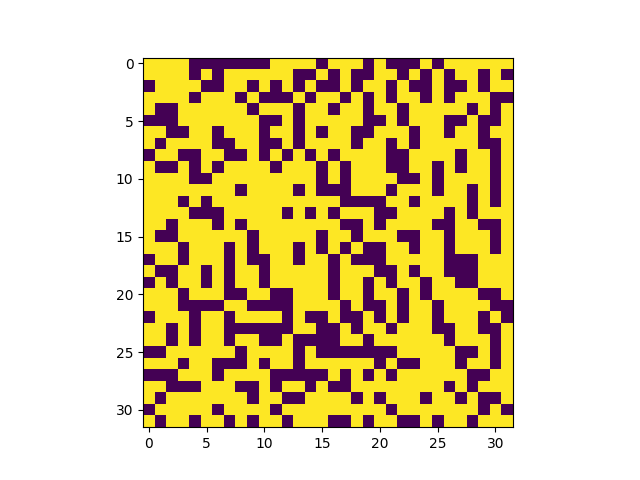

In [116]:
plt.close("all")
plt.imshow(act[1200])
plt.show()

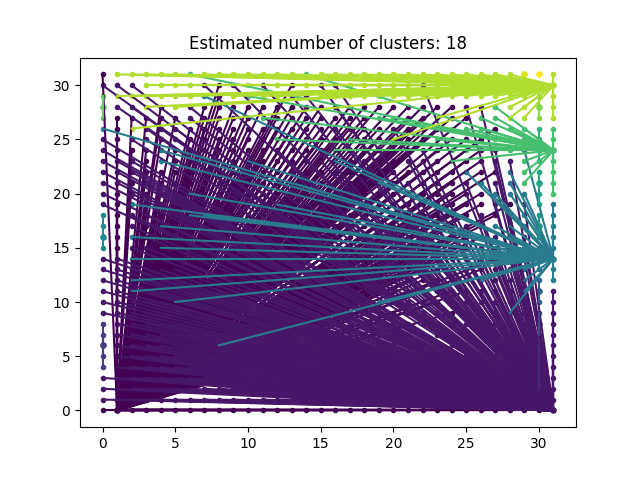

In [111]:
X = np.meshgrid(np.arange(act.shape[-2]), np.arange(act.shape[-1]))
X = np.stack([X[0].ravel(), X[1].ravel()], axis=1)

plt.close("all")
plt.figure(1)
plt.clf()


colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_clusters_)))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.scatter(
        X[class_members, 0], X[class_members, 1], color=col["color"], marker="."
    )
    plt.scatter(
        cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o"
    )
    for x in X[class_members]:
        plt.plot(
            [cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"]
        )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

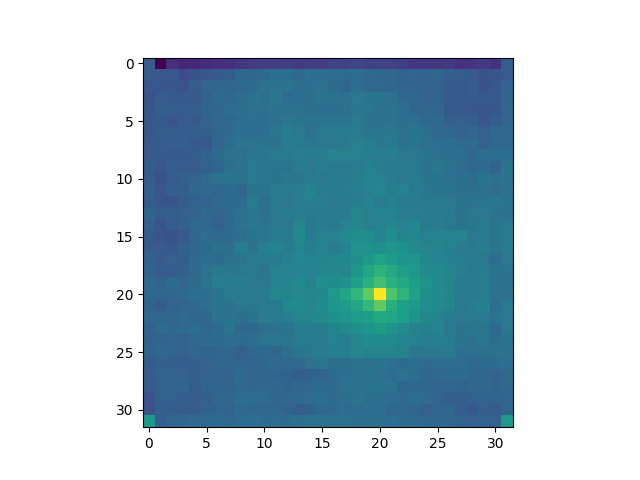

In [36]:
plt.imshow(sim[660].reshape(32, 32))
plt.show()

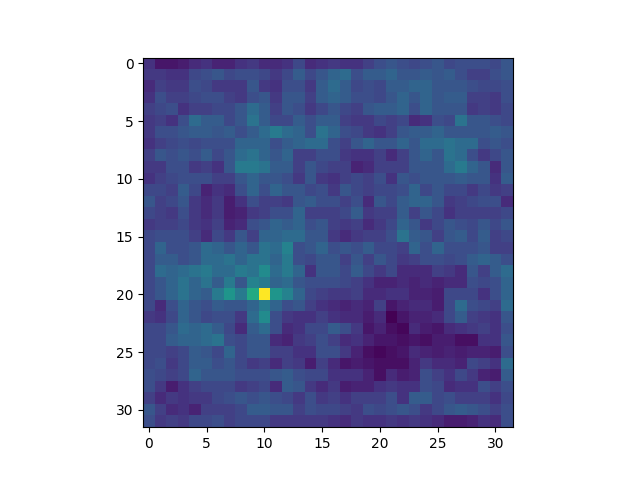

In [16]:
plt.imshow(sim[650].reshape(32, 32))
plt.show()

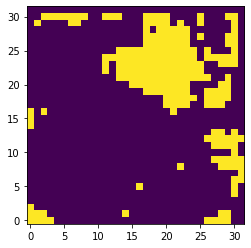

In [23]:
plt.imshow(hook.activations['backbone.layer1.0.bn1'][4][17], origin='lower')
plt.show()

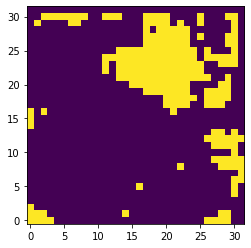

In [8]:
plt.imshow(hook.activations['backbone.layer1.0.bn1'][4][17], origin='lower')
plt.show()

In [22]:
type(hook.activations['backbone.layer1.0.bn1'][0])

numpy.ndarray

In [28]:
model.backbone

ResNet_CIFAR_V2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): ResLayer(
    (0): BasicBlockV2(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (drop_path): Identity()
      (relu_1): ReLU(inplace=True)
      (relu_2): ReLU(inplace=True)
    )
    (1): BasicBlockV2(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2

In [90]:
dict(model.named_modules()).keys()

dict_keys(['', 'backbone', 'backbone.conv1', 'backbone.bn1', 'backbone.relu', 'backbone.layer1', 'backbone.layer1.0', 'backbone.layer1.0.conv1', 'backbone.layer1.0.bn1', 'backbone.layer1.0.conv2', 'backbone.layer1.0.bn2', 'backbone.layer1.0.relu', 'backbone.layer1.0.drop_path', 'backbone.layer1.0.relu_1', 'backbone.layer1.0.relu_2', 'backbone.layer1.1', 'backbone.layer1.1.conv1', 'backbone.layer1.1.bn1', 'backbone.layer1.1.conv2', 'backbone.layer1.1.bn2', 'backbone.layer1.1.relu', 'backbone.layer1.1.drop_path', 'backbone.layer1.1.relu_1', 'backbone.layer1.1.relu_2', 'backbone.layer2', 'backbone.layer2.0', 'backbone.layer2.0.conv1', 'backbone.layer2.0.bn1', 'backbone.layer2.0.conv2', 'backbone.layer2.0.bn2', 'backbone.layer2.0.relu', 'backbone.layer2.0.downsample', 'backbone.layer2.0.downsample.0', 'backbone.layer2.0.downsample.1', 'backbone.layer2.0.drop_path', 'backbone.layer2.0.relu_1', 'backbone.layer2.0.relu_2', 'backbone.layer2.1', 'backbone.layer2.1.conv1', 'backbone.layer2.1.bn1

In [86]:
dict(model.named_modules()).keys()

dict_keys(['', 'backbone', 'backbone.conv1', 'backbone.bn1', 'backbone.relu', 'backbone.layer1', 'backbone.layer1.0', 'backbone.layer1.0.conv1', 'backbone.layer1.0.bn1', 'backbone.layer1.0.conv2', 'backbone.layer1.0.bn2', 'backbone.layer1.0.relu', 'backbone.layer1.0.drop_path', 'backbone.layer1.0.relu_1', 'backbone.layer1.0.relu_2', 'backbone.layer1.1', 'backbone.layer1.1.conv1', 'backbone.layer1.1.bn1', 'backbone.layer1.1.conv2', 'backbone.layer1.1.bn2', 'backbone.layer1.1.relu', 'backbone.layer1.1.drop_path', 'backbone.layer1.1.relu_1', 'backbone.layer1.1.relu_2', 'backbone.layer2', 'backbone.layer2.0', 'backbone.layer2.0.conv1', 'backbone.layer2.0.bn1', 'backbone.layer2.0.conv2', 'backbone.layer2.0.bn2', 'backbone.layer2.0.relu', 'backbone.layer2.0.downsample', 'backbone.layer2.0.downsample.0', 'backbone.layer2.0.downsample.1', 'backbone.layer2.0.drop_path', 'backbone.layer2.0.relu_1', 'backbone.layer2.0.relu_2', 'backbone.layer2.1', 'backbone.layer2.1.conv1', 'backbone.layer2.1.bn1